In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

df = pd.read_csv("../data/freq_data.csv")
df = df[(df["Exposure"] > 0) & (df["Exposure"] <= 1)].copy()

y = df["ClaimNb"].astype(float).values
X = pd.get_dummies(df.drop(columns=["ClaimNb"]), drop_first=True).astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.2, random_state=42
)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True)


In [2]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Softplus()  # output must be positive
        )
    def forward(self, x):
        return self.layers(x)

model = Net(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()


In [3]:
loss_history = []

for epoch in range(30):
    model.train()
    
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    loss_history.append(loss.item())
    print(f"Epoch {epoch+1}/30 - Loss: {loss.item():.5f}")


Epoch 1/30 - Loss: 0.03294
Epoch 2/30 - Loss: 0.06456
Epoch 3/30 - Loss: 0.07773
Epoch 4/30 - Loss: 0.04875
Epoch 5/30 - Loss: 0.05007
Epoch 6/30 - Loss: 0.03162
Epoch 7/30 - Loss: 0.06588
Epoch 8/30 - Loss: 0.06983
Epoch 9/30 - Loss: 0.04480
Epoch 10/30 - Loss: 0.05270
Epoch 11/30 - Loss: 0.06456
Epoch 12/30 - Loss: 0.04348
Epoch 13/30 - Loss: 0.06588
Epoch 14/30 - Loss: 0.09091
Epoch 15/30 - Loss: 0.06061
Epoch 16/30 - Loss: 0.04348
Epoch 17/30 - Loss: 0.05402
Epoch 18/30 - Loss: 0.05665
Epoch 19/30 - Loss: 0.05007
Epoch 20/30 - Loss: 0.13439
Epoch 21/30 - Loss: 0.07642
Epoch 22/30 - Loss: 0.03689
Epoch 23/30 - Loss: 0.06324
Epoch 24/30 - Loss: 0.06983
Epoch 25/30 - Loss: 0.05929
Epoch 26/30 - Loss: 0.08432
Epoch 27/30 - Loss: 0.06719
Epoch 28/30 - Loss: 0.05665
Epoch 29/30 - Loss: 0.07246
Epoch 30/30 - Loss: 0.04875


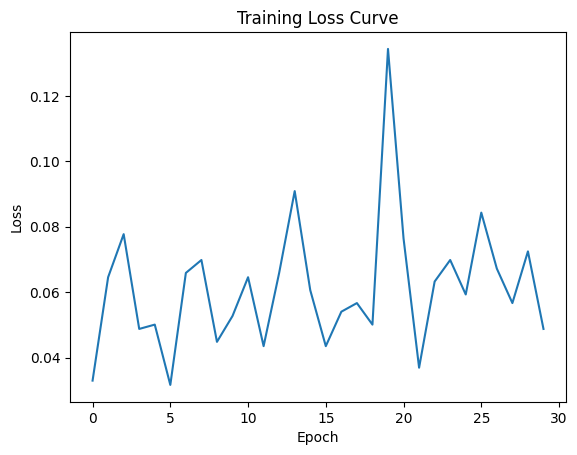

In [4]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [5]:
model.eval()
nn_pred = model(X_test_t).detach().numpy().flatten()

nn_mae = mean_absolute_error(y_test, nn_pred)
nn_rmse = np.sqrt(mean_squared_error(y_test, nn_pred))

nn_mae, nn_rmse


(0.05240176892607754, 0.24291246652065757)